In [1]:
import os, sys, gc
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
conf = spark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = spark.SparkContext(master='local', appName='myAppName',conf=conf)
sql = spark.SQLContext(sc)

In [2]:
sys.path.append("/home/fvalle/phd/TWO-NN/")
from TwoNN import twonn_dimension

In [3]:
os.chdir("/home/fvalle/phd/datasets/gtex/log/10")

In [4]:
genes = sql.read.option("header",'true').csv('/home/fvalle/phd/master_thesis/genes.txt')
genes.registerTempTable("genes")
genes.select("type_of_gene").distinct().show()
pc = sql.sql("SELECT * FROM genes WHERE type_of_gene='protein-coding'")

+--------------+
|  type_of_gene|
+--------------+
|          rRNA|
|         ncRNA|
|       unknown|
|         scRNA|
|      microRNA|
|         snRNA|
|     antisense|
|        snoRNA|
|        pseudo|
|protein-coding|
|    intergenic|
+--------------+



In [5]:
pc_list=pd.read_csv("http://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel().astype(str)

In [6]:
df = sql.read.option("header",True).option("delimiter",'\t').csv("/home/fvalle/phd/datasets/gtex/10/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz")
df = df.withColumn('ensg',udf(lambda x: x[:15], StringType())(col('Name')))
df = df.withColumn('type',udf(lambda x: 'pc' if x in pc_list else 'nc', StringType())(col('ensg')))
df.registerTempTable("df")
df = sql.sql("SELECT * FROM df WHERE type='pc'")

In [7]:
df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t').loc[:,['SAMPID','SMTS', 'SMTSD']]
df_files.set_index('SAMPID', inplace=True)
df_files = df_files.reindex(index=df.columns).dropna(how='all', axis=0)

In [8]:
tissues = df_files.groupby('SMTS').count().sort_values('SMTSD', ascending=False).index

In [9]:
model=PCA()

In [12]:
selected = []
expl_var = {}
twonn_dims = []
N=100
for i in np.arange(1,len(tissues)-1,1,dtype=int):
    print(i)
    selected=np.concatenate((selected, df_files[df_files['SMTS']==tissues[i]][:N].index.values))
    np.random.shuffle(selected)
    data=df.select(list(selected)).toPandas().astype(float).applymap(lambda x: np.log(x+1)).transpose().astype(float).values
    model.fit(data)
    expl_var[i]=model.explained_variance_
    twonn_dims.append(twonn_dimension(data))
    gc.collect()

1
2
3
4
5
6
7
8
9
10
11
12
13


Py4JJavaError: An error occurred while calling o9524.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 26.0 failed 1 times, most recent failure: Lost task 0.0 in stage 26.0 (TID 217, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1853)
	at java.io.ObjectOutputStream.write(ObjectOutputStream.java:709)
	at org.apache.spark.util.Utils$.writeByteBuffer(Utils.scala:260)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply$mcV$sp(TaskResult.scala:50)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1326)
	at org.apache.spark.scheduler.DirectTaskResult.writeExternal(TaskResult.scala:48)
	at java.io.ObjectOutputStream.writeExternalData(ObjectOutputStream.java:1459)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1430)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:517)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1853)
	at java.io.ObjectOutputStream.write(ObjectOutputStream.java:709)
	at org.apache.spark.util.Utils$.writeByteBuffer(Utils.scala:260)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply$mcV$sp(TaskResult.scala:50)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1326)
	at org.apache.spark.scheduler.DirectTaskResult.writeExternal(TaskResult.scala:48)
	at java.io.ObjectOutputStream.writeExternalData(ObjectOutputStream.java:1459)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1430)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:517)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 56444)
Traceback (most recent call last):
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark

In [13]:
try:
    pd.DataFrame(data=expl_var).to_csv("intr_dim.csv")
except:
    pass
try:
    pd.DataFrame(data=twonn_dims).to_csv("twonn.csv")
except:
    pass

In [14]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34489)
Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop 

In [60]:
np.cumsum(expl_var[3])

array([1346.75998652, 2082.22807573, 2590.19277214, ...,           nan,
                 nan,           nan])

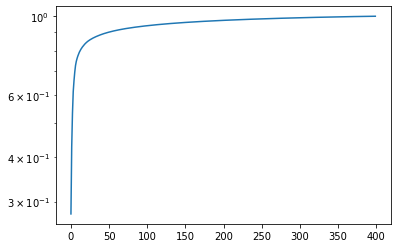

In [61]:
fig, ax=plt.subplots()
#list(map(lambda data: ax.plot(data[1]), expl_var.items()))
ax.plot(np.cumsum(expl_var[3])/np.nansum(expl_var[3]))
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim(1e-1,1e5)
plt.show()

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


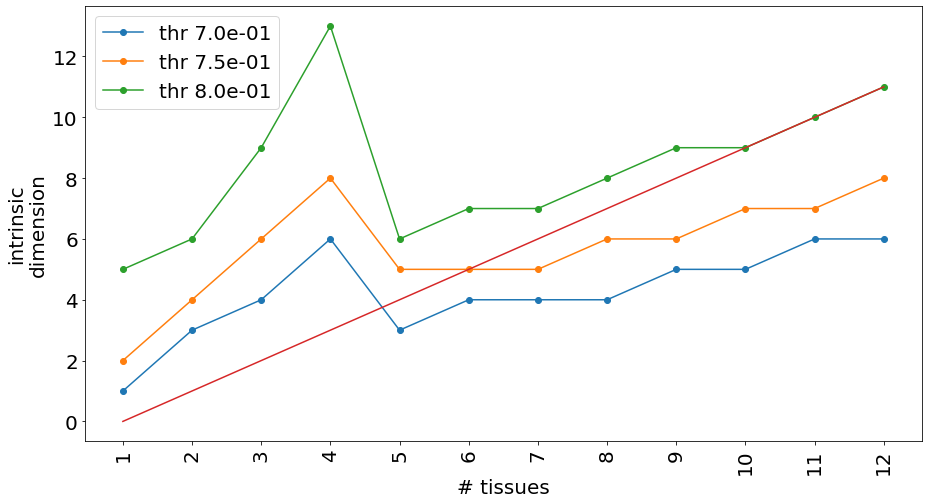

In [69]:
x=np.array([i for i in expl_var.keys()])
parab = lambda x,a,b,c: a+ b*x+c*x*x
fig=plt.figure(figsize=(15,8))
for thr in [0.7,0.75,0.8]:
    plot_data=[]
    for k in expl_var.keys():
        var=np.array(expl_var[k])
        var = np.cumsum(var)/np.nansum(var)
        plot_data.append(len(var[var<thr]))
    #par, pot = curve_fit(parab, x,plot_data)
    #plt.plot(x, parab(x, *par), ls=':', lw=2, label="%d+%.2f x%.3f xx"%(par[0],par[1],par[2]))
    plt.plot(x,plot_data, marker='o', label="thr %.1e"%thr)
plt.xlabel('# tissues', fontsize=20)
plt.ylabel('intrinsic\ndimension', fontsize=20)
plt.plot(x,x)
#plt.plot(x,1.06*x+2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
n_tissues=np.array([n for n in expl_var.keys()])
plt.xticks(ticks=n_tissues, labels=n_tissues+1, rotation=90)
plt.show()
fig.savefig("intrinsic_dimension.pdf")

In [70]:
plot_data

[5, 6, 9, 13, 6, 7, 7, 8, 9, 9, 10, 11]

In [30]:
pd.DataFrame(data=list(map(lambda x: np.concatenate([expl_var[x],[np.nan for _ in range(1200-len(expl_var[x]))]]), expl_var))).to_csv("intrdim.csv",index=False, header=True)

In [44]:
df_ev=pd.read_csv("intrdim.csv",  header=0).transpose()
df_ev.columns=df_ev.columns.astype(int)
expl_var=df_ev.to_dict('list')

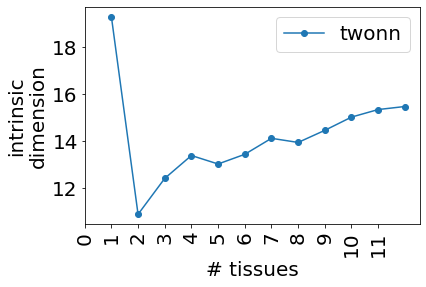

In [48]:
fig=plt.figure()
plt.plot(twonn_dims, marker='o', label='twonn')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('# tissues', fontsize=20)
plt.ylabel('intrinsic\ndimension', fontsize=20)
#plt.ylim(6,11)
n_tissues=np.array([n for n in expl_var.keys()])
plt.xticks(ticks=n_tissues-1, labels=n_tissues, rotation=90)
plt.show()
fig.savefig("intrinsic_dimension_twonn.pdf")

In [ ]:
sc.stop()